In [1]:
# importing libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from math import sqrt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
# loading the data 

intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)

In [3]:
print(f'Random Forest - Data Pre-processing\n')
print(f'Before building and loading a random forest model, we will pre-process the data. To do so, we added the new zip code variables for 00801 and 00804 and converted the zip bins and sex variables to dummies.\n ') 

Random Forest - Data Pre-processing

Before building and loading a random forest model, we will pre-process the data. To do so, we added the new zip code variables for 00801 and 00804 and converted the zip bins and sex variables to dummies.
 


In [4]:
# setting up variables to track column names as needed

rvar = "res1_yes"
evar = [
    "zip_bins_1",
    "zip_bins_2",
    "zip_bins_3",
    "zip_bins_4",
    "zip_bins_5",
    "zip_bins_6",
    "zip_bins_7",
    "zip_bins_8",
    "zip_bins_9",
    "zip_bins_10",
    "zip_bins_11",
    "zip_bins_12",
    "zip_bins_13",
    "zip_bins_14",
    "zip_bins_15",
    "zip_bins_16",
    "zip_bins_17",
    "zip_bins_18",
    "zip_bins_19",
    "zip_bins_20",
    "numords",
    "dollars",
    "last",
    "version1",
    "bizflag",
    "sincepurch",
    "owntaxprod",
    "upgraded",
    "zip801",
    "zip804",
    "sex_Male",
    "sex_Female",
    "sex_Unknown",
]
idvar="id"

In [5]:
# converting types of variables and creation of necessary new variables

intuit75k["zip_bins"] = intuit75k["zip_bins"].astype("category")
intuit75k["version1"] = intuit75k["version1"].astype("category")
intuit75k["owntaxprod"] = intuit75k["owntaxprod"].astype("category")
intuit75k["upgraded"] = intuit75k["upgraded"].astype("category")
intuit75k["bizflag"] = intuit75k["bizflag"].astype("category")

intuit75k["zip801"] = (intuit75k["zip"] == "00801").astype(int)
intuit75k["zip804"] = (intuit75k["zip"] == "00804").astype(int)
intuit75k["zip801"] = intuit75k["zip801"].astype("category")
intuit75k["zip804"] = intuit75k["zip804"].astype("category")

In [6]:
# creation of necessary dummy variables

int_std = intuit75k.copy()
pq= pd.get_dummies(
    int_std[
        [
            "zip_bins","sex"
        ]
    ]
)
int_std = int_std.join(pq)
train = int_std[int_std['training'] == 1]
test = int_std[int_std['training'] == 0]

In [7]:
# dataframe for storing the results for evaluation of different models

eval_dat = pd.concat([train, test], axis=0)
eval_dat = eval_dat[[idvar, rvar, "training"]]

X_train = train[evar]
y_train = train[rvar]
X_test = test[evar]
y_test = test[rvar]

In [8]:
print(f'Random Forest Model \n') 

Random Forest Model 



In [9]:
# Random Forest base model

clf = RandomForestClassifier(
    n_estimators=100, max_features=3, oob_score=True, random_state=1234
).fit(X_train, y_train)

In [10]:
# Predictions of base model

eval_dat["y_rf"] = clf.predict_proba(pd.concat((X_train, X_test), axis=0))[:, 1]
eval_dat["y_rf_oob"] = 0  
eval_dat.loc[eval_dat.training == 1, "y_rf_oob"] = clf.oob_decision_function_[:, 1]
eval_dat.loc[eval_dat.training == 0, "y_rf_oob"] = clf.predict_proba(X_test)[:, 1]

Evalbin commented out for gitlab purposes

In [11]:
# # Evaluation bin

# dct = {
#     "training": eval_dat[eval_dat.training == 1],
#     "test": eval_dat[eval_dat.training == 0],
# }
# rsm.evalbin(dct, "res1_yes", 1, ["y_rf", "y_rf_oob"], cost=1.41, margin=60)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_rf,2498,9942,40060,0,52500,1.000,0.801,0.201,0.334,0.811,0.277,132339.60,1.000,7.545,0.237,1.000
1,training,y_rf_oob,1873,24075,25927,625,52500,0.750,0.519,0.072,0.132,0.530,0.049,75793.32,0.573,2.072,0.494,0.706
2,test,y_rf,775,8891,12506,328,22500,0.703,0.584,0.080,0.144,0.590,0.061,32870.94,1.000,2.412,0.430,0.712
3,test,y_rf_oob,775,8891,12506,328,22500,0.703,0.584,0.080,0.144,0.590,0.061,32870.94,1.000,2.412,0.430,0.712


In [12]:
print(f'Cross validation to get best parameters \n') 

Cross validation to get best parameters 



In [13]:
# Random Forest with cross validation and grid search

clf1 = RandomForestClassifier()
param_grid = {
    "n_estimators": list(range(100, 501, 100)),
    "max_features": range(3, 5),
    "max_depth": range(5,8),
    "random_state": [200],
}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV(
    clf1, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5,
).fit(X_train, y_train)

print(f"""The best parameters are {clf_cv.best_params_}""")
print(f"""The best score is {clf_cv.best_score_}""")
pred = clf_cv.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train.values, pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
print(f"""The AUC for the prediction is {auc_rf}\n""")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
The best parameters are {'max_depth': 7, 'max_features': 4, 'n_estimators': 400, 'random_state': 200}
The best score is 0.7634082841204135
The AUC for the prediction is 0.7952042006390201



In [14]:
print(f'Final Random Forest model with best parameters \n')

Final Random Forest model with best parameters 



In [15]:
# Final model with best parameters

clf_final = RandomForestClassifier(
    n_estimators = clf_cv.best_params_["n_estimators"],
    max_features = clf_cv.best_params_["max_features"],
    oob_score = True,
    random_state = 200,
    max_depth = 11,
    
).fit(X_train, y_train)
pred_final = clf.oob_decision_function_
fpr, tpr, thresholds = metrics.roc_curve(y_train.values, pred_final[:, 1])
auc_rf = metrics.auc(fpr, tpr)
print(f"""The AUC score of final model is {auc_rf}""")

The AUC score of final model is 0.7059964919257514


In [16]:
# Predictions on final model

eval_dat["y_rf_cv"] = 0  
eval_dat.loc[eval_dat.training == 1, "y_rf_cv"] = clf_final.oob_decision_function_[:, 1]
eval_dat.loc[eval_dat.training == 0, "y_rf_cv"] = clf_final.predict_proba(X_test)[:, 1]

In [17]:
print(f'Profit Calculations and Plots \n')

Profit Calculations and Plots 



In [18]:
# calculating the profit for wave-1 on test set

testing_set = eval_dat[eval_dat["training"] == 0]
nn_prof1 = rsm.profit(
    pred = pd.Series(eval_dat["y_rf_cv"]),
    rvar = testing_set["res1_yes"],
    lev = 1,
    cost = 1.41,
    margin = 60,
)

print(f"""The Profit for test set in wave 1 is ${int(nn_prof1):,} """)

The Profit for test set in wave 1 is $37,725 


In [19]:
# calculating the profit for wave-2

def w2_profit(resp):
    # calculating the profit for wave-2 on test set
    breakeven = 1.41 / 60
    wave2_target = 763334
    eval_dat['mod_resp'] = eval_dat[resp] * 0.5
    eval_dat['mod_mail'] = eval_dat['mod_resp'] > breakeven
    df=eval_dat[eval_dat['training']==0]
    
    mail_true = sum(df['mod_mail']) #num of yes in test set
    mail_true_rate = mail_true / df.shape[0] #proportion to yes is test set
    buy_true = df[(df['mod_mail']==True) & (df['res1_yes']==1)] #true positives
    
    mail_number = wave2_target * mail_true_rate 
    adjusted_rr = (buy_true.shape[0] * 0.5) / mail_true
    wave2_buyers = adjusted_rr * mail_number
   
    mail_cost = 1.41 * mail_number
    profit = 60 * wave2_buyers - mail_cost
    rome = profit / mail_cost
    
    return profit,rome

In [20]:
scaled_prof, scaled_rome = w2_profit("y_rf_cv")


print(
    f"""Wave-2 Scaled Campaign: The Profit is ${int(scaled_prof):,} and the the return on investment is {round(float(scaled_rome)*100,2):,}% """
)

Wave-2 Scaled Campaign: The Profit is $442,131 and the the return on investment is 137.21% 


In [21]:
# lift and gains plot

def plot(resp):
    # lift and gains plot
    w = 13
    h = 4
    d = 100
    fig = plt.figure(figsize=(w, h), dpi=d)
    fig.suptitle(f"Cumulative Lift and Gains For Random Forest Model")

    fig1 = fig.add_subplot(122)
    fig1.set_title("Cumulative Gains")
    fig1 = rsm.gains_plot(
        {
            "Training": eval_dat.query("training == 1"),
            "Test": eval_dat.query("training == 0"),
        },
        rvar="res1_yes",
        pred=resp,
        lev=1,
        qnt=10,
    )

    fig2 = fig.add_subplot(121)
    fig2.set_title("Cumulative Lift")
    fig2 = rsm.lift_plot(
        {
            "Training": eval_dat.query("training == 1"),
            "Test": eval_dat.query("training == 0"),
        },
        rvar="res1_yes",
        pred=resp,
        lev=1,
        qnt=10,
    )

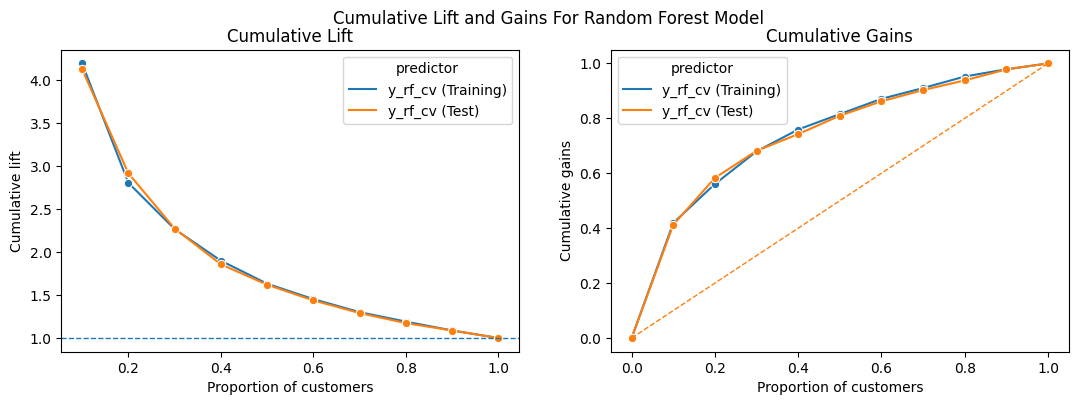

In [22]:
plot('y_rf_cv')

In [23]:
eval_dat.to_csv("./data/Random.csv", index=False)